<div align="center"> 
    <br><br>
    <img src="https://raw.githubusercontent.com/Nikoletos-K/pyJedAI/main/documentation/pyjedai.logo.drawio.png?raw=true" alt="drawing" width="400"/>
    <br>
    <hr>
    <font size="3">Clean-Clean Entity Resolution Tutorial</font>
    <br>
</div>
<hr>


In this notebook we present the pyJedAI approach in the well-known ABT-BUY dataset. Clean-Clean ER in the link discovery/deduplication between two sets of entities.

Dataset: __Abt-Buy dataset__

The Abt-Buy dataset for entity resolution derives from the online retailers Abt.com and Buy.com. The dataset contains 1076 entities from abt.com and 1076 entities from buy.com as well as a gold standard (perfect mapping) with 1076 matching record pairs between the two data sources. The common attributes between the two data sources are: product name, product description and product price.

# Instalation

pyJedAI is an open-source library that can be installed from PyPI.

For more: [pypi.org/project/pyjedai/](https://pypi.org/project/pyjedai/)

In [ ]:
!pip install pyjedai

In [ ]:
!pip show pyjedai

Imports

In [2]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

In [3]:
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write

# Workflow Architecture

![workflow-example.png](https://github.com/Nikoletos-K/pyJedAI/blob/main/documentation/workflow-example.png?raw=true)

# Data Reading

pyJedAI in order to perfrom needs only the tranformation of the initial data into a pandas DataFrame. Hence, pyJedAI can function in every structured or semi-structured data. In this case Abt-Buy dataset is provided as .csv files. 


In [7]:
from pyjedai.datamodel import Data

In [9]:
d1 = pd.read_csv("./../data/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./../data/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./../data/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

data.process()

pyJedAI offers also dataset analysis methods (more will be developed)

In [10]:
data.print_specs()

Type of Entity Resolution:  Clean-Clean
Number of entities in D1:  1076
Attributes provided  for D1:  ['id', 'name', 'description']

Number of entities in D2:  1076
Attributes provided  for D2:  ['id', 'name', 'description']

Total number of entities:  2152
Number of matching pairs in ground-truth:  1076


In [11]:
data.dataset_1.head(5)

,id,name,description,price
0,0,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,
1,1,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399
2,2,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,49
3,3,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,
4,4,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,158


In [12]:
data.dataset_2.head(5)

,id,name,description,price
0,0,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,Linksys EtherFast 8-Port 10/100 Switch (New/Wo...,
1,1,Linksys EtherFast EZXS55W Ethernet Switch,5 x 10/100Base-TX LAN,
2,2,Netgear ProSafe FS105 Ethernet Switch - FS105NA,NETGEAR FS105 Prosafe 5 Port 10/100 Desktop Sw...,
3,3,Belkin Pro Series High Integrity VGA/SVGA Moni...,1 x HD-15 - 1 x HD-15 - 10ft - Beige,
4,4,Netgear ProSafe JFS516 Ethernet Switch,Netgear ProSafe 16 Port 10/100 Rackmount Switc...,


In [13]:
data.ground_truth.head(3)

,D1,D2
0,206,216
1,60,46
2,182,160


# Block Building

It clusters entities into overlapping blocks in a lazy manner that relies on unsupervised blocking keys: every token in an attribute value forms a key. Blocks are then extracted, possibly using a transformation, based on its equality or on its similarity with other keys.

The following methods are currently supported:

- Standard/Token Blocking
- Sorted Neighborhood
- Extended Sorted Neighborhood
- Q-Grams Blocking
- Extended Q-Grams Blocking
- Suffix Arrays Blocking
- Extended Suffix Arrays Blocking

In [14]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

In [15]:
qgb = QGramsBlocking()
blocks = qgb.build_blocks(data, attributes_1=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [16]:
qgb.report()

Method name: Q-Grams Blocking
Method info: Creates one block for every q-gram that is extracted from any token in the attribute values of any entity. The q-gram must be shared by at least two entities.
Parameters: 
	Q-Gramms: 6
Attributes from D1:
	name
Attributes from D2:
	id, name, description, price
Runtime: 0.2931 seconds


In [17]:
e = Evaluation(data)
e.report(blocks, qgb.method_configuration())

# Q-Grams Blocking Evaluation 
---
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.2931 seconds
Scores:
	Precision:      0.23% 
	Recall:        99.91%
	F1-score:       0.45%
Classification report:
	True positives: 1075
	False positives: 471355
	True negatives: 686420
	False negatives: 1
	Total comparisons: 472430
---


#### OR with an EmbeddingsNNBlockBuilding

In [ ]:
emb = EmbeddingsNNBlockBuilding(
    vectorizer='bert',
    similarity_search='faiss'
)
blocks = emb.build_blocks(data)

In [8]:
Evaluation(data).report(blocks, emb.method_configuration())

# Embeddings-NN Block Building Evaluation 
---
Method name: Embeddings-NN Block Building
Parameters: 
	Vectorizer: xlnet
	Similarity-Search: faiss
	Top-K: 30
	Vector size: 768
Runtime: 929.3534 seconds
Scores:
	Precision:      0.15% 
	Recall:         4.55%
	F1-score:       0.29%
Classification report:
	True positives: 49
	False positives: 32231
	True negatives: 1124518
	False negatives: 1027
	Total comparisons: 32280
---


# Block Cleaning

___Optional step___

Its goal is to clean a set of overlapping blocks from unnecessary comparisons, which can be either redundant (i.e., repeated comparisons that have already been executed in a previously examined block) or superfluous (i.e., comparisons that involve non-matching entities). Its methods operate on the coarse level of individual blocks or entities.

In [18]:
from pyjedai.block_cleaning import BlockFiltering

In [19]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|                                                                           | 0/3 [00:00<…

In [20]:
Evaluation(data).report(filtered_blocks, bf.method_configuration())

# Block Filtering Evaluation 
---
Method name: Block Filtering
Parameters: 
	Ratio: 0.8
Runtime: 0.0618 seconds
Scores:
	Precision:      0.77% 
	Recall:        99.63%
	F1-score:       1.52%
Classification report:
	True positives: 1072
	False positives: 138721
	True negatives: 1019051
	False negatives: 4
	Total comparisons: 139793
---


# Comparison Cleaning

___Optional step___

Similar to Block Cleaning, this step aims to clean a set of blocks from both redundant and superfluous comparisons. Unlike Block Cleaning, its methods operate on the finer granularity of individual comparisons.

The following methods are currently supported:

- Comparison Propagation
- Cardinality Edge Pruning (CEP)
- Cardinality Node Pruning (CNP)
- Weighed Edge Pruning (WEP)
- Weighed Node Pruning (WNP)
- Reciprocal Cardinality Node Pruning (ReCNP)
- Reciprocal Weighed Node Pruning (ReWNP)
- BLAST

Most of these methods are Meta-blocking techniques. All methods are optional, but competive, in the sense that only one of them can part of an ER workflow. For more details on the functionality of these methods, see here. They can be combined with one of the following weighting schemes:

- Aggregate Reciprocal Comparisons Scheme (ARCS)
- Common Blocks Scheme (CBS)
- Enhanced Common Blocks Scheme (ECBS)
- Jaccard Scheme (JS)
- Enhanced Jaccard Scheme (EJS)

In [21]:
from pyjedai.block_cleaning import BlockPurging

In [22]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/6454 [00:00<?, ?it/s]

In [23]:
cbbp.report()

Method name: Block Purging
Method info: Discards the blocks exceeding a certain number of comparisons.
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3528.0
Runtime: 0.0410 seconds


In [24]:
e = Evaluation(data)
e.report(cleaned_blocks, cbbp.method_configuration())

# Block Purging Evaluation 
---
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3528.0
Runtime: 0.0410 seconds
Scores:
	Precision:      0.80% 
	Recall:        99.63%
	F1-score:       1.59%
Classification report:
	True positives: 1072
	False positives: 133001
	True negatives: 1024771
	False negatives: 4
	Total comparisons: 134073
---


## Meta Blocking

In [25]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [26]:
wep = CardinalityEdgePruning(weighting_scheme='X2')
candidate_pairs_blocks = wep.process(filtered_blocks, data, tqdm_disable=True)

In [27]:
Evaluation(data).report(candidate_pairs_blocks, wep.method_configuration())

# Cardinality Edge Pruning Evaluation 
---
Method name: Cardinality Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: X2
Runtime: 2.1447 seconds
Scores:
	Precision:      8.31% 
	Recall:        95.35%
	F1-score:      15.28%
Classification report:
	True positives: 1026
	False positives: 11326
	True negatives: 1146400
	False negatives: 50
	Total comparisons: 12352
---


# Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [28]:
from pyjedai.matching import EntityMatching

In [29]:
EM = EntityMatching(
    metric='sorensen_dice',
    similarity_threshold=0.5,
    attributes = ['description', 'name']
)

pairs_graph = EM.predict(candidate_pairs_blocks, data, tqdm_disable=True)

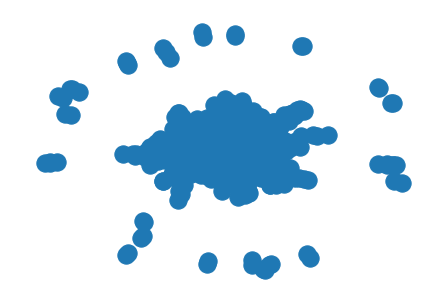

In [30]:
draw(pairs_graph)

In [31]:
Evaluation(data).report(pairs_graph, EM.method_configuration())

# Entity Matching Evaluation 
---
Method name: Entity Matching
Parameters: 
	Metric: sorensen_dice
	Embeddings: None
	Attributes: ['description', 'name']
	Similarity threshold: 0.5
Runtime: 5.7848 seconds
Scores:
	Precision:      2.78% 
	Recall:        23.33%
	F1-score:       4.97%
Classification report:
	True positives: 251
	False positives: 8764
	True negatives: 1148187
	False negatives: 825
	Total comparisons: 9015
---


# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [32]:
from pyjedai.clustering import ConnectedComponentsClustering

In [33]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph)

In [34]:
ccc.report()

Method name: Connected Components Clustering
Method info: Gets equivalence clusters from the transitive closure of the similarity graph.
Runtime: 0.0030 seconds


In [35]:
Evaluation(data).report(clusters)

#  Evaluation 
---
Scores:
	Precision:      0.10% 
	Recall:        88.66%
	F1-score:       0.20%
Classification report:
	True positives: 954
	False positives: 970235
	True negatives: 187419
	False negatives: 122
	Total comparisons: 971189
---


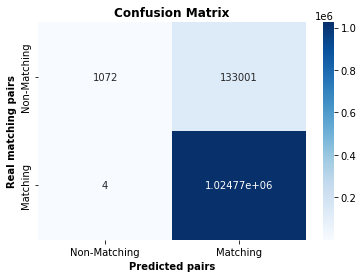

In [36]:
e.confusion_matrix()

<hr>
<div align="right">
K. Nikoletos, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>